In [29]:
import torch
from emonet import EmoNet
import os
import random
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torch.nn.functional as F
random.seed(42)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmoNet(n_expression=8)
model.load_state_dict(torch.load("D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\cfd_finetuned_emonet_100_epochs.pth"))
model.to(device)
model.eval()

### Preparing data for Happy Female (B and W)

In [3]:
#defining image transform
cfd_transform=transforms.Compose([ transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])])

In [18]:
def tensor_to_cv2(img_tensor):
    img_tensor = img_tensor.squeeze(0).cpu()
    inv_transform = transforms.Compose([
        transforms.Normalize(mean=[0.], std=[1 / 0.5]),
        transforms.Normalize(mean=[-0.5], std=[1.]),  # Undo Normalize(mean=0.5, std=0.5)
        transforms.ToPILImage()
    ])
    img = inv_transform(img_tensor)
    img_np = np.array(img)
    
    if img_np.ndim == 2:  # grayscale
        img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2BGR)
    else:
        img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)

    return img_np

In [19]:
def superimpose_feature_maps(conv4_activations, orig_img, selected_indices=None, title=''):
    activations = conv4_activations.detach().cpu()
    if selected_indices is not None:
        activations = activations[selected_indices, :, :]
    
    activations = torch.relu(activations)  #ReLU
    combined_map = activations.sum(dim=0).numpy()

    combined_map -= combined_map.min()
    combined_map /= combined_map.max() + 1e-8
    combined_map *= 255
    combined_map = combined_map.astype(np.uint8)
    combined_map = cv2.resize(combined_map, (256, 256))
    heatmap = cv2.applyColorMap(combined_map, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(orig_img, 0.5, heatmap, 0.5, 0)

    # Show
    plt.figure(figsize=(6, 6))
    plt.imshow(overlay[..., ::-1])
    plt.title(title)
    plt.axis('off')
    plt.show()


In [4]:
#loading images from folders
def load_images(path):
    images_list=[]
    filenames=os.listdir(path)
    for file in filenames:
        img_path=os.path.join(path,file)
        image = Image.open(img_path).convert("RGB")  # Ensure it's in RGB mode
        image = cfd_transform(image)
        images_list.append(image)
    return torch.stack(images_list)

In [6]:
path1="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\Black\\Happy_ClosedMouth"
path2="D:\Integrated_gap_gradients\ig2_CNN\gpu_env_ig2\Male\White\\Happy_ClosedMouth"  #change accordingly

b_imglist=load_images(path1)
w_imglist=load_images(path2)

print("Black Neutral Images Shape:", b_imglist.shape)
print("White Neutral Images Shape:", w_imglist.shape)

#we've loaded corresponding images

Black Neutral Images Shape: torch.Size([32, 3, 256, 256])
White Neutral Images Shape: torch.Size([36, 3, 256, 256])


### Analyzing for conv4, last conv layer before hourglass block

In [7]:
#observing last conv_layer before hourglass block, conv_4
black_feature_maps_dict = {}
def hook_fn(module, input, output):
    black_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [8]:
#observing last conv_layer before hourglass block, conv_4
white_feature_maps_dict = {}
def hook_fn(module, input, output):
    white_feature_maps_dict["conv4"] = output.detach()

hook_handle = model.conv4.register_forward_hook(hook_fn)

In [9]:
black_feature_maps=[]
white_feature_maps=[]

with torch.no_grad():
    for i in range(b_imglist.shape[0]):
        image = b_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        black_feature_maps.append(black_feature_maps_dict["conv4"])

In [10]:

with torch.no_grad():
    for i in range(w_imglist.shape[0]):
        image = w_imglist[i].unsqueeze(0)
        image=image.to(device)
        model(image)
        white_feature_maps.append(white_feature_maps_dict["conv4"]) 

In [11]:
wfm_tensor=torch.stack(white_feature_maps)
bfm_tensor=torch.stack(black_feature_maps)

In [12]:
wfm_tensor.shape

torch.Size([36, 1, 256, 64, 64])

In [13]:
black_mean_activation = bfm_tensor.mean(dim=0) 
white_mean_activation = wfm_tensor.mean(dim=0) 

activation_difference = black_mean_activation - white_mean_activation

#averaging activations of feature maps for all images of black and white, and taking their absolute difference.

print("Black Mean Activation Shape:", black_mean_activation.shape)
print("White Mean Activation Shape:", white_mean_activation.shape)
print("Activation Difference Shape:", activation_difference.shape)

Black Mean Activation Shape: torch.Size([1, 256, 64, 64])
White Mean Activation Shape: torch.Size([1, 256, 64, 64])
Activation Difference Shape: torch.Size([1, 256, 64, 64])


In [14]:
black_mean_activation = black_mean_activation.squeeze(0).cpu().detach().numpy()  
white_mean_activation = white_mean_activation.squeeze(0).cpu().detach().numpy()  
activation_difference = activation_difference.squeeze(0).cpu().detach().numpy()  

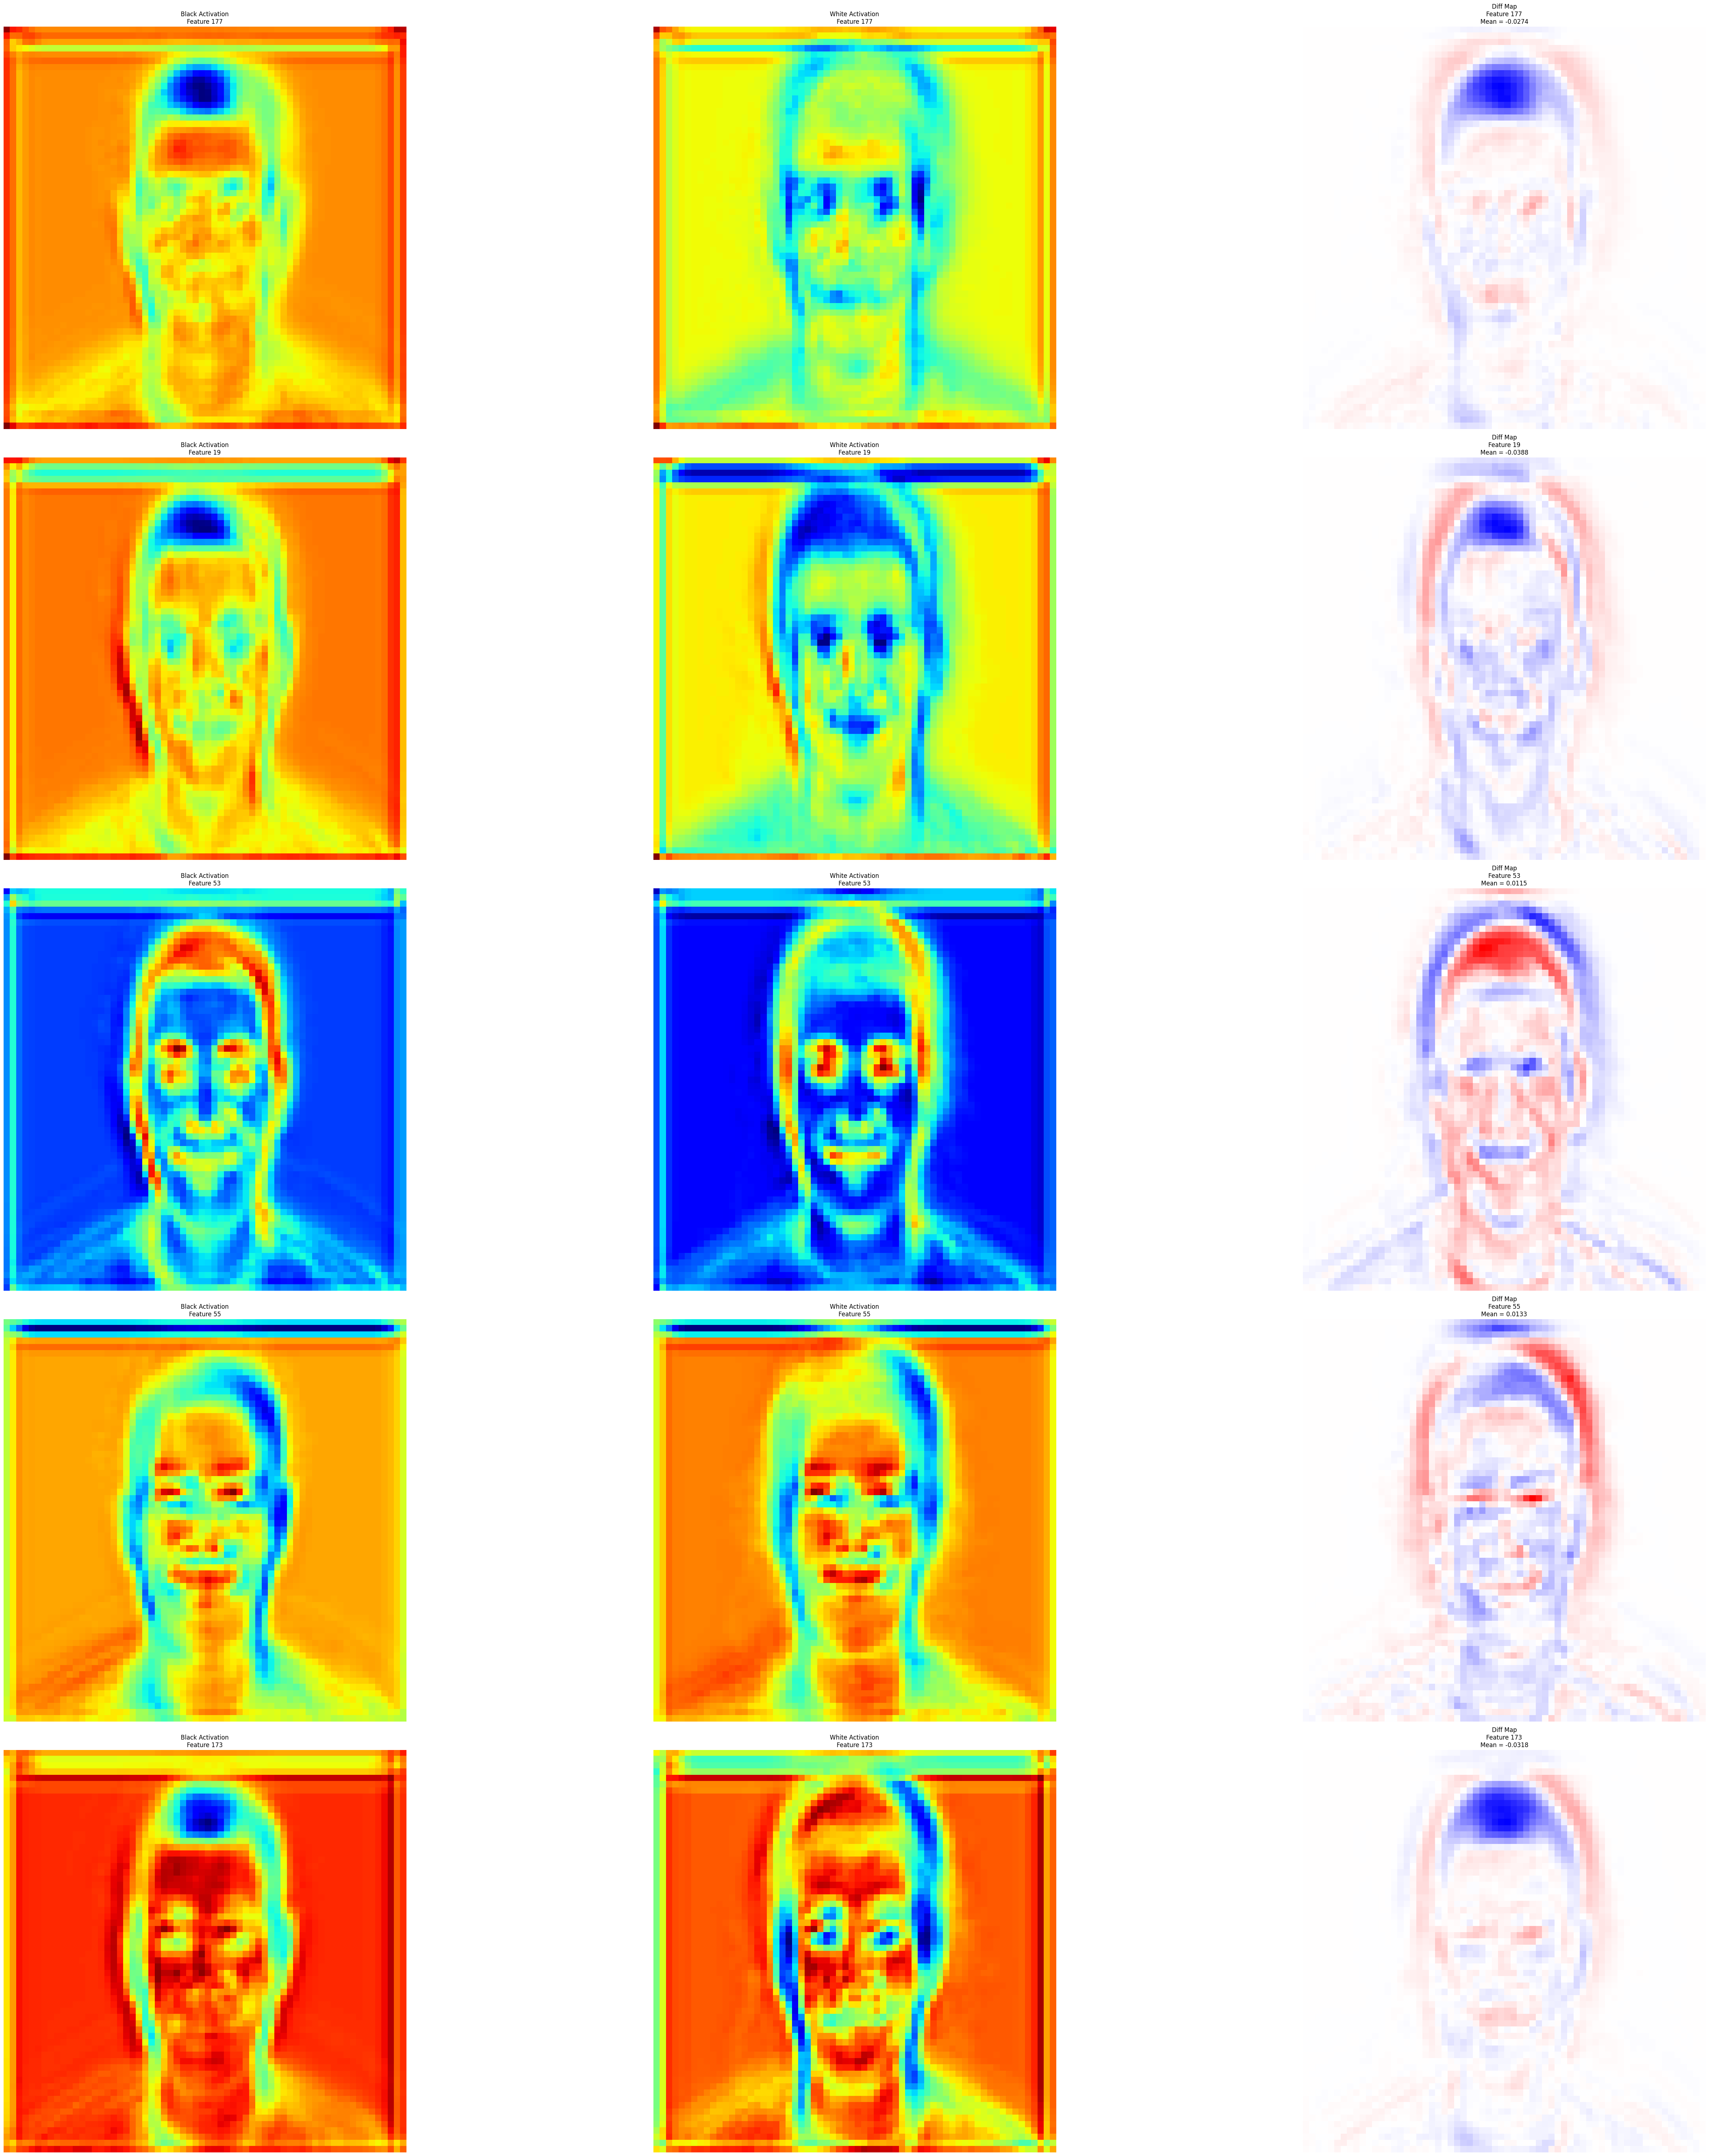

In [16]:
feature_map_index = [177, 19, 53, 55,173]
fig, axes = plt.subplots(len(feature_map_index), 3, figsize=(60, 60))

for i, index in enumerate(feature_map_index):
    black_activation_map = black_mean_activation[index]
    white_activation_map = white_mean_activation[index]
    difference_map = activation_difference[index]

    # Signed mean of the difference map (White - Black)
    signed_diff = np.mean(difference_map)

    axes[i, 0].imshow(black_activation_map, cmap='jet')
    axes[i, 0].set_title(f"Black Activation\nFeature {index}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(white_activation_map, cmap='jet')
    axes[i, 1].set_title(f"White Activation\nFeature {index}")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(
        difference_map, cmap='bwr', 
        vmin=-np.max(np.abs(difference_map)), 
        vmax=np.max(np.abs(difference_map))
    )
    axes[i, 2].set_title(f"Diff Map\nFeature {index}\nMean = {signed_diff:.4f}")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


In [ ]:
def get_conv4_activations(image_tensor, model, suppressed_indices=None):
    activations = {}

    def conv4_hook(module, input, output):
        if suppressed_indices is not None:
            output = output.clone()
            output[:, suppressed_indices, :, :] = 0
        activations["conv4"] = output

    handle = model.conv4.register_forward_hook(conv4_hook)

    with torch.no_grad():
        _ = model(image_tensor.to(next(model.parameters()).device))

    handle.remove()
    return activations["conv4"].squeeze(0).cpu() 

def visualize_activation_difference(image_tensor, model, suppressed_indices, title="Activation Diff (Pre - Post)", figsize=(6, 6)):
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post 

    diff_map = A_diff.sum(dim=0)
    diff_map = (diff_map - diff_map.min()) / (diff_map.max() - diff_map.min() + 1e-5)

    resized_diff = F.interpolate(
        diff_map.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False
    ).squeeze()

    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(orig)
    plt.imshow(resized_diff, cmap='bwr', alpha=0.5)
    plt.axis("off")
    plt.title(title)
    plt.show()


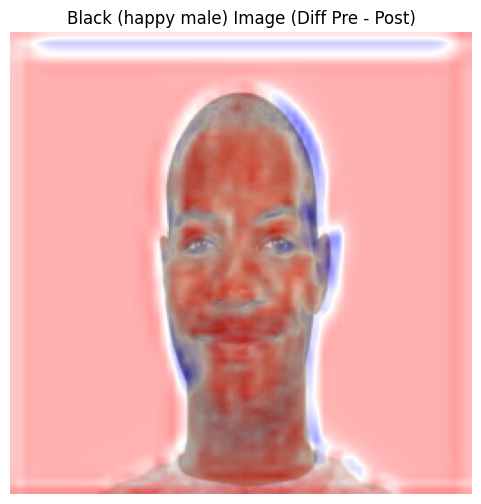

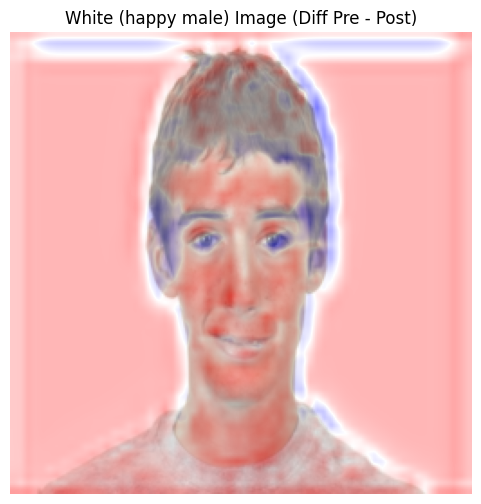

In [39]:
# Example usage
suppressed_indices = [177, 19, 53, 55, 173]
visualize_activation_difference(b_imglist[0].unsqueeze(0), model, suppressed_indices, title="Black (happy male) Image (Diff Pre - Post)")
visualize_activation_difference(w_imglist[0].unsqueeze(0), model, suppressed_indices, title="White (happy male) Image (Diff Pre - Post)")


In [40]:
def visualize_pre_post_diff(image_tensor, model, suppressed_indices, figsize=(18, 6)):
    # Get activations
    A_pre = get_conv4_activations(image_tensor, model)
    A_post = get_conv4_activations(image_tensor, model, suppressed_indices=suppressed_indices)
    A_diff = A_pre - A_post  # [C, H, W]

    # Sum across channels
    pre_map = A_pre.sum(dim=0)
    post_map = A_post.sum(dim=0)
    diff_map = A_diff.sum(dim=0)

    # Normalize each map individually (retain signed values for diff_map)
    pre_map_norm = (pre_map - pre_map.min()) / (pre_map.max() - pre_map.min() + 1e-5)
    post_map_norm = (post_map - post_map.min()) / (post_map.max() - post_map.min() + 1e-5)

    # For signed diff map, normalize but preserve sign
    max_abs = diff_map.abs().max() + 1e-5
    diff_map_norm = diff_map / max_abs  # Now in range [-1, 1]

    # Resize to match image size
    pre_map_resized = F.interpolate(pre_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    post_map_resized = F.interpolate(post_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()
    diff_map_resized = F.interpolate(diff_map_norm.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze()

    # Prepare original image
    orig = image_tensor.squeeze(0).permute(1, 2, 0).cpu()  # [H, W, 3]
    orig = (orig * 0.5 + 0.5).clamp(0, 1).numpy()

    # Plot all three
    fig, axs = plt.subplots(1, 3, figsize=figsize)

    axs[0].imshow(orig)
    axs[0].imshow(pre_map_resized, cmap='jet', alpha=0.5)
    axs[0].set_title(f"Pre-Suppression")
    axs[0].axis("off")

    axs[1].imshow(orig)
    axs[1].imshow(post_map_resized, cmap='jet', alpha=0.5)
    axs[1].set_title(f"Post-Suppression")
    axs[1].axis("off")

    im = axs[2].imshow(orig)
    im = axs[2].imshow(diff_map_resized, cmap='bwr', alpha=0.5)
    axs[2].set_title(f"(Pre - Post)")
    axs[2].axis("off")


    plt.tight_layout()
    plt.show()

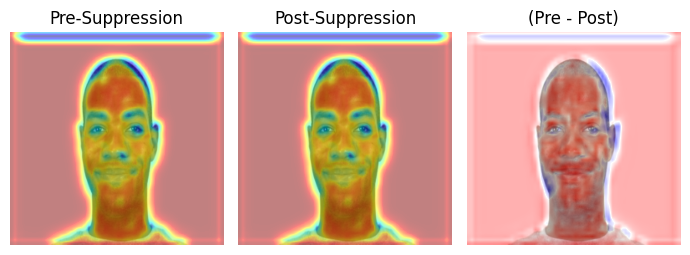

In [47]:
visualize_pre_post_diff(
    image_tensor=b_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)

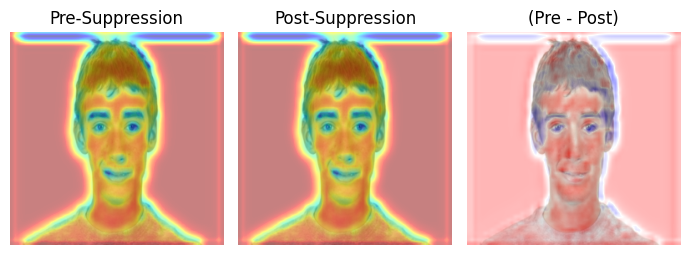

In [46]:
visualize_pre_post_diff(
    image_tensor=w_imglist[0].unsqueeze(0),
    model=model,
    suppressed_indices=suppressed_indices,
    figsize=(7, 6)
)